In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# date of datas
date = "0913"

# arguments
cam_H, cam_W = 580, 890
wvls = np.arange(430, 670, 10)
wvls = np.delete(wvls, -4)

n_illum = 318
n_patches = 24
n_channel = 3

patch_idx = np.arange(0, 24)
patch_size = 3

# dir
first_order_data_dir = './calibration/first_order_position_line_pattern/2023%s'%date

# center points for all patches
all_patches_center_pts = np.array([[210, 130], [324,142], [442,142], [558, 147], [680,152], [792,154],
[200,250], [326,253], [440,256], [560, 260], [676,261], [792,267],
[190,366], [318,372], [440,372], [558,376], [676,380], [794,379],
[190,490], [314,496], [436,491], [558,492], [678,495], [800,495]])

### Bring band pass filter captured image

In [3]:
first_order_data = []

exp_indx = 1

for i in range(318): 
    first_order_dir = os.path.join(first_order_data_dir, '%snm_crop/calibration00/capture_%04d.png')

    first_order_imgs = np.array([cv2.imread(first_order_dir%(wvls[w], i), -1)[:,:,::-1] for w in range(len(wvls))])
    first_order_data.append(first_order_imgs)
    
first_order_data = np.array(first_order_data) # 318, 25, 580, 890, 3

### Save or bring band pass filter captured image for each wvl, rgb

In [3]:
# np.save('./first_order_data.npy', first_order_data)
first_order_data = np.load('./first_order_data.npy')

In [4]:
first_order_data.shape # illumination index, wvls, H, W, rgb

(318, 23, 580, 890, 3)

In [5]:
first_order_data_transposed = first_order_data.transpose(2,3,0,1,4)
print(first_order_data_transposed.shape) # H, W, illumination index, wvls, rgb

(580, 890, 318, 23, 3)


### Save data for each patches for each wavelengths

In [6]:
# plot reflectance for each patches - real
# patches : 24개, wvl : 25 개
patches_rgb_real = np.zeros(shape = (n_illum, n_patches, len(wvls)))
patches_idx = all_patches_center_pts

cnst = 1
patch_size = 3

# max value defined for each illumination pattern 

for w in range(len(wvls)):
    for l in range(318):
        y_idx_start, y_idx_end = (patches_idx[:,1] - patch_size//2).astype(np.int32), (patches_idx[:,1] + patch_size//2).astype(np.int32)
        x_idx_start, x_idx_end = (patches_idx[:,0] - patch_size//2).astype(np.int32), (patches_idx[:,0] + patch_size//2).astype(np.int32)
            
        for p in range(n_patches):
                y_idx, x_idx = patches_idx[p,1], patches_idx[p,0]
                rgb_intensity = (first_order_data_transposed[y_idx_start[p]:y_idx_end[p], x_idx_start[p]:x_idx_end[p], l, w] / (65535)).reshape(-1, 3).mean(axis = 0)
                max_idx = np.argmax(rgb_intensity) # rgb 채널 중 max 값 넣기

                patches_rgb_real[l, p, w] = rgb_intensity[max_idx] # illum index, patch, wvls

### Find first order dispersed light peak illumination index

In [ ]:
peak_illum_idx = np.zeros(shape=(n_patches, len(wvls)))

In [ ]:
np.argmax(patches_rgb_real[:220,17, 0]), patches_rgb_real[:,18, 0].min()

163

0, 6, 12, 18 번 patch는 zero index 가 대략 100 임 & +1 order 빛

1, 7, 13, 19 번 patch는 zero index 가 대략 140 임 & +1 order 빛

2, 8, 14, 20 번 patch는 zero index 가 대략 160 임 & -1 order 빛

3, 9, 15, 21 번 patch는 zero index 가 대략 200 임 & -1 order 빛

4, 10, 16, 22 번 patch는 zero index 가 대략 240 임 & -1 order 빛

5, 11, 17, 23 번 patch는 zero index 가 대략 270 임 & -1 order 빛

<참고>

12번의 blue patch는 마지막 660nm 인덱스는 261로 매뉴얼하게 넣음

2 번의 patch 는 마지막 660nm 빛이 아예 안찍힘

8 번의 patch 는 마지막 660nm 빛이 아예 안찍힘

23 번의 patch는 첫번째 430nm 인덱스는 166로 메뉴얼하게 넣음

In [ ]:
patch_num = 6

c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


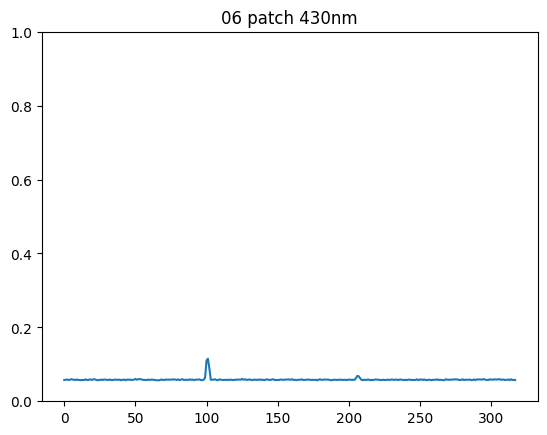

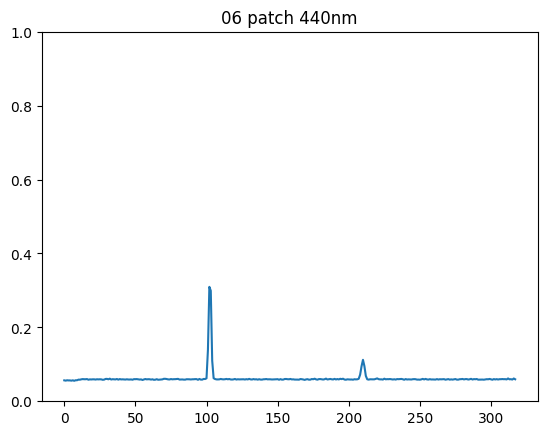

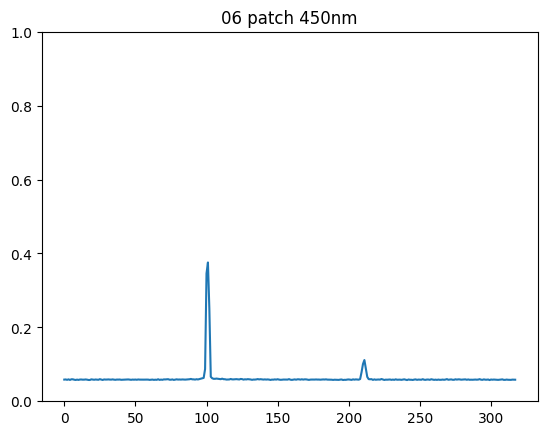

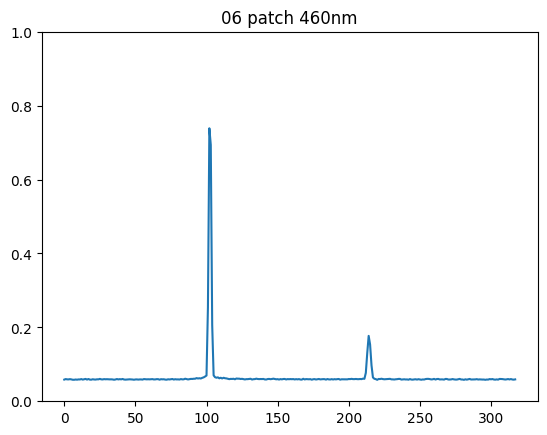

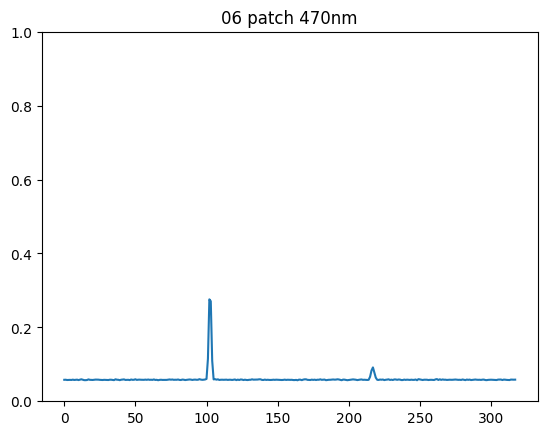

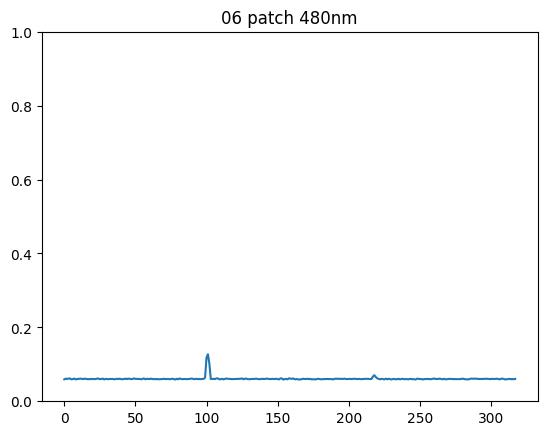

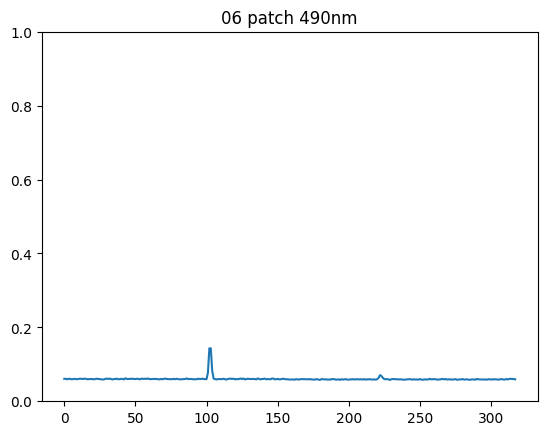

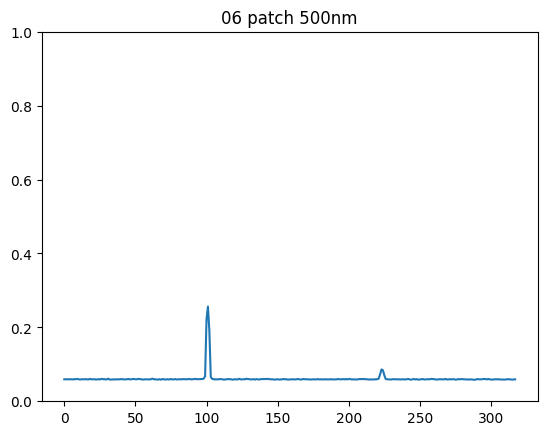

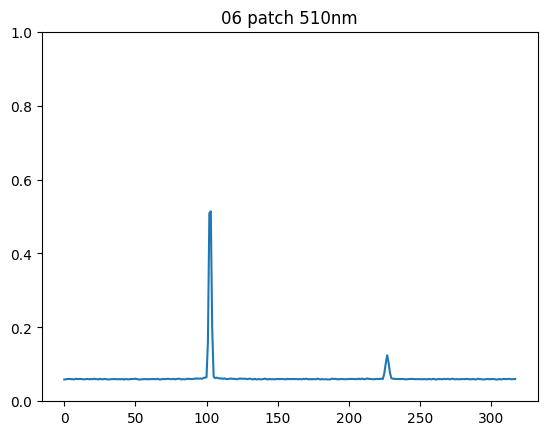

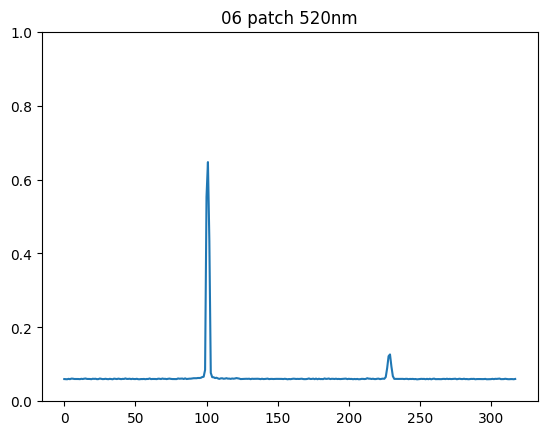

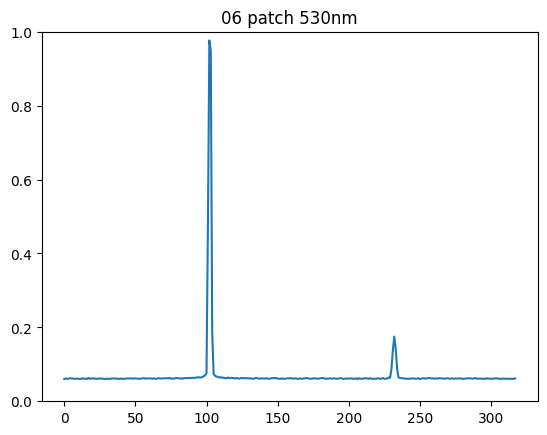

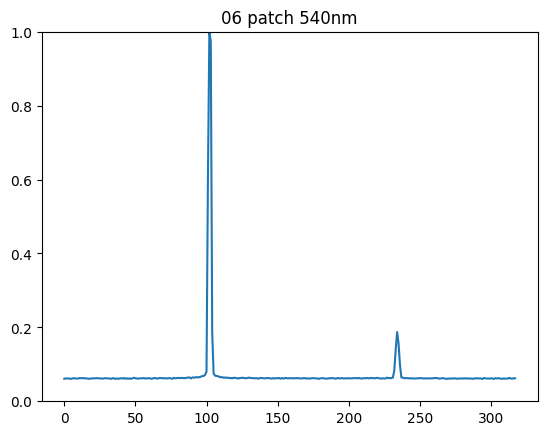

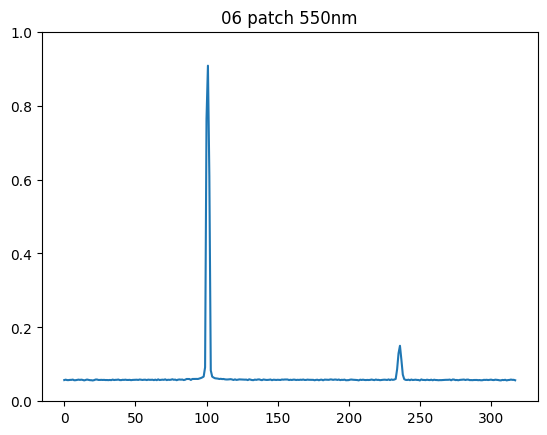

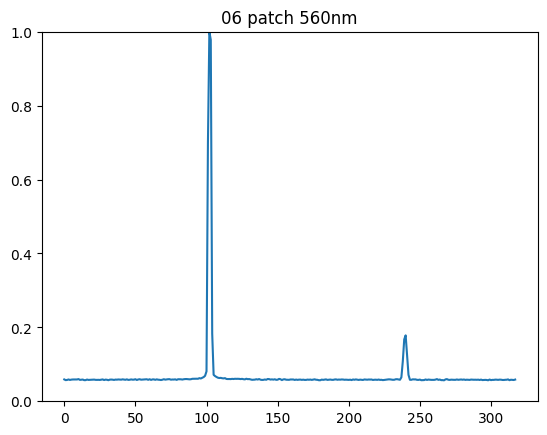

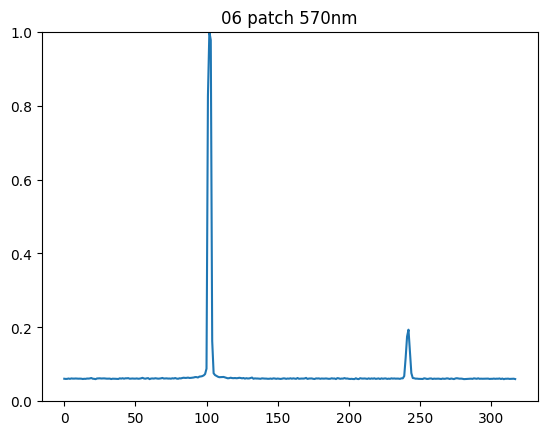

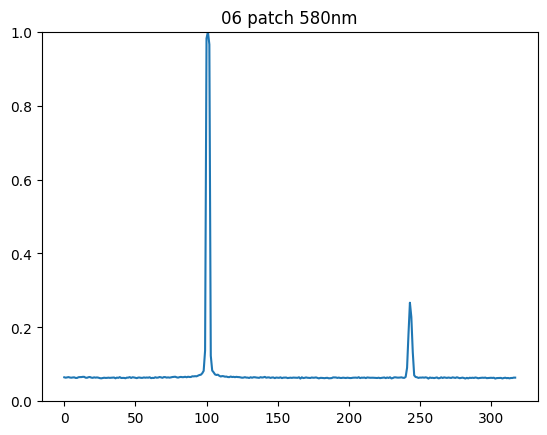

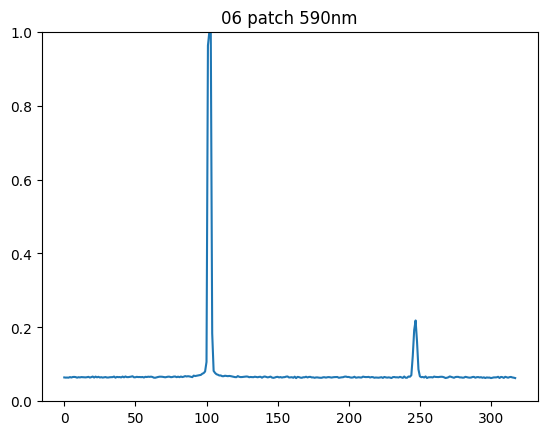

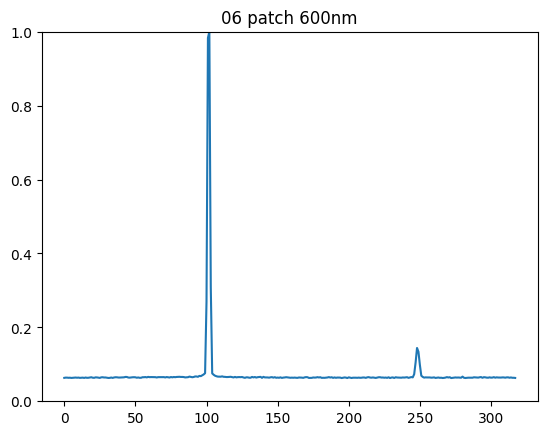

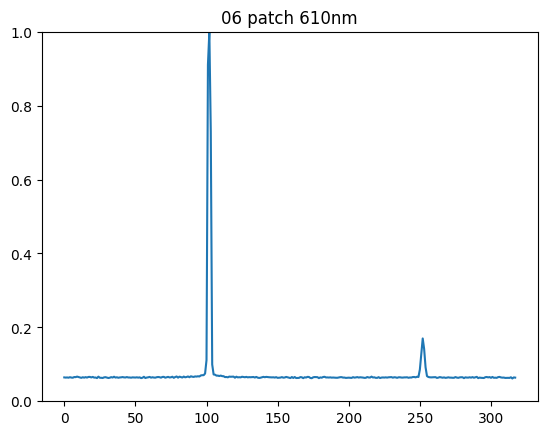

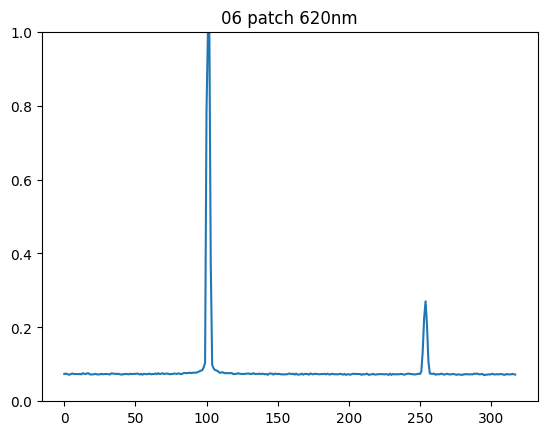

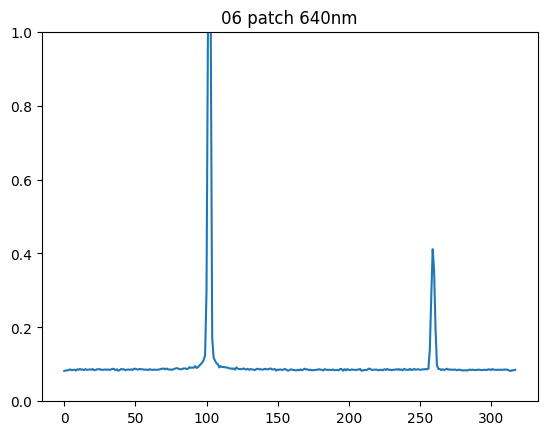

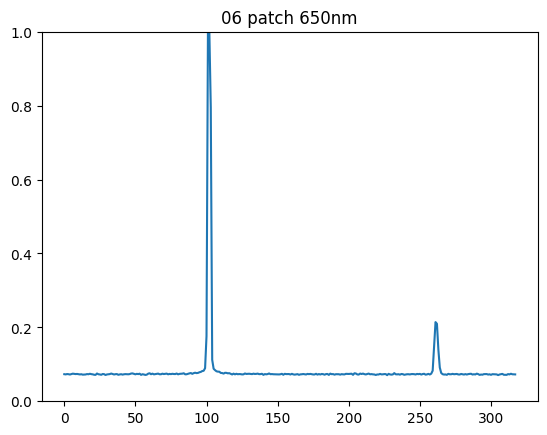

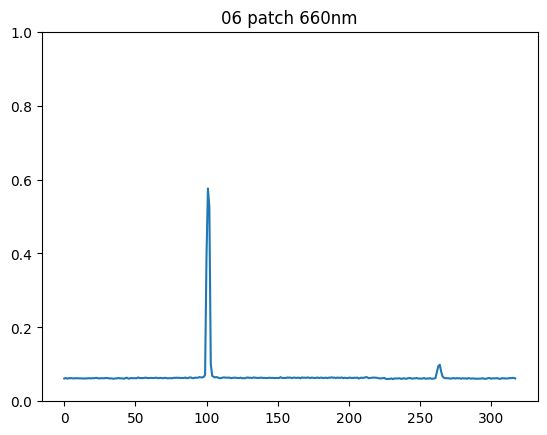

In [ ]:
# patches_rgb_real (318, 24, 23)

zero_idx = 250

for p in range(patch_num, patch_num + 1):
    # if (p == 0) or (p == 6) or (p == 12) or (p == 18): # +1
    #     zero_idx = 120
    
    # elif (p == 1) or (p == 7) or (p == 13) or (p == 19): # +1
    #     zero_idx = 140
    
    # elif (p == 2) or (p == 8) or (p == 14) or (p == 20): # -1
    #     zero_idx = 150
    
    # elif (p == 3) or (p == 9) or (p == 15) or (p == 21): # -1
    #     zero_idx = 180
    
    # elif (p == 4) or (p == 10) or (p == 16) or (p == 22): # -1
    #     zero_idx = 220
    
    # elif (p == 5) or (p == 11) or (p == 17) or (p == 23): # -1
    #     zero_idx = 250
        
    for w in range(len(wvls)):
        plt.figure()
        plt.ylim([0, 1])
        plt.plot(patches_rgb_real[:,p, w]), plt.title('%02d patch %dnm'%(p, wvls[w]))
        
        # # for +1 orders
        # max_idx = np.argmax(patches_rgb_real[zero_idx:,p, w]) + zero_idx
        # peak_illum_idx[p, w] = max_idx
        
        # # for -1 orders
        # max_idx = np.argmax(patches_rgb_real[:zero_idx,p, w])
        # peak_illum_idx[p, w] = max_idx

In [ ]:
# 18 : 203 - 260 // zero 101
# 17 : 163 - 110 // zero 268
# 12 : 204 - 258 // zero 99
# 13 : 239 - 297 // zero 134
# 14 : 63 - 4 // zero 168

In [ ]:
peak_illum_idx[patch_num, 0] = 166

[430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600
 610 620 640 650 660]
[166. 165. 162. 161. 158. 155. 153. 150. 149. 144. 143. 141. 138. 137.
 134. 131. 129. 127. 124. 121. 118. 116. 113.]


([<matplotlib.lines.Line2D at 0x1bbd9581cc8>], Text(0.5, 1.0, '23 patch'))

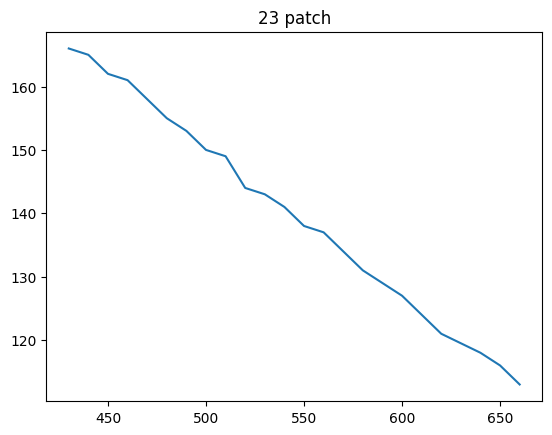

In [ ]:
print(wvls)
print(peak_illum_idx[patch_num])
plt.plot(wvls, peak_illum_idx[patch_num]), plt.title('%02d patch'%patch_num)

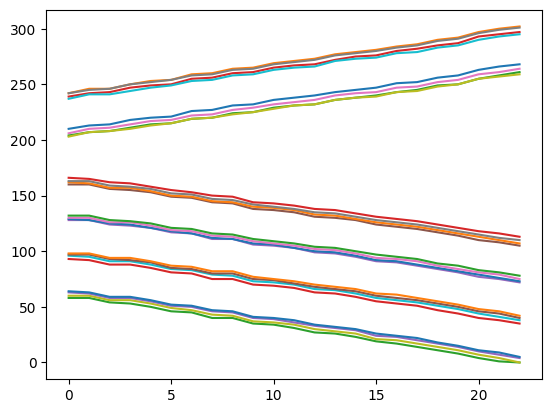

In [ ]:
for i in range(len(peak_illum_idx)):
    plt.plot(peak_illum_idx[i])

In [ ]:
# np.save('./peak_illum_idx.npy', peak_illum_idx)

### Bring first order illumination index

In [8]:
peak_illum_idx = np.load('./peak_illum_idx.npy')

### Find zero order index

In [9]:
zero_illum_idx = np.zeros(shape=(n_patches, len(wvls)))

c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


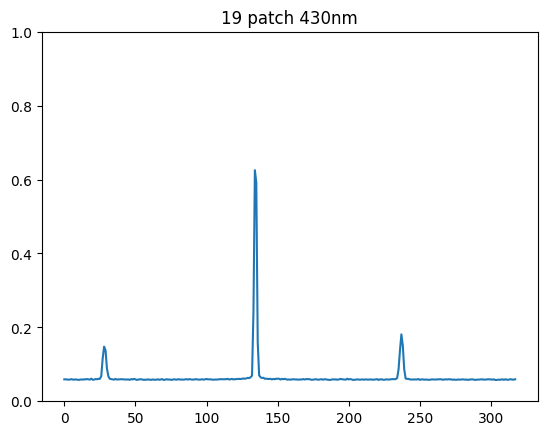

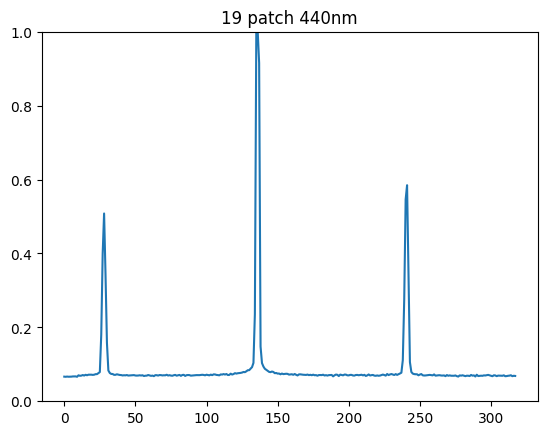

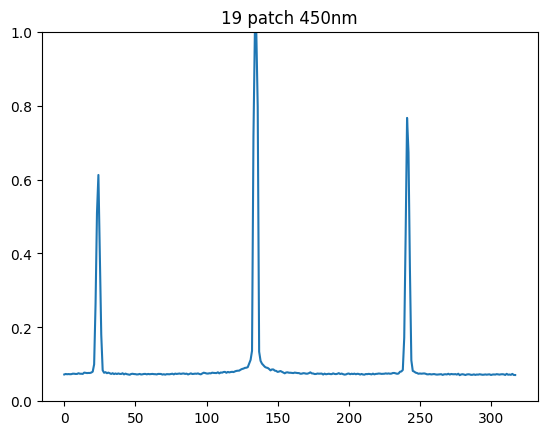

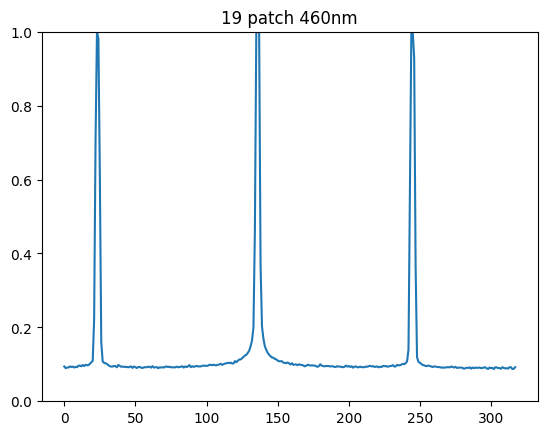

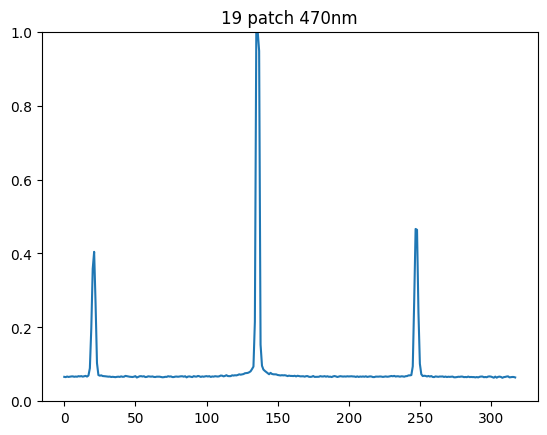

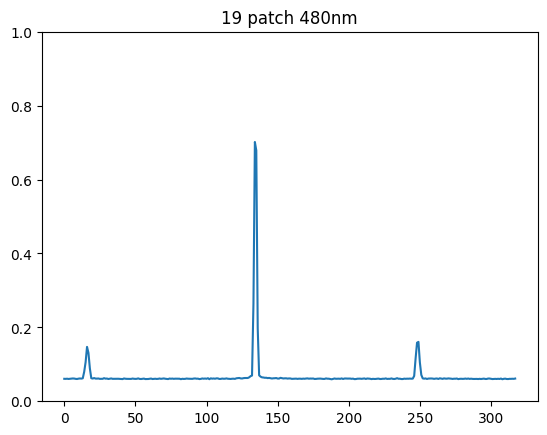

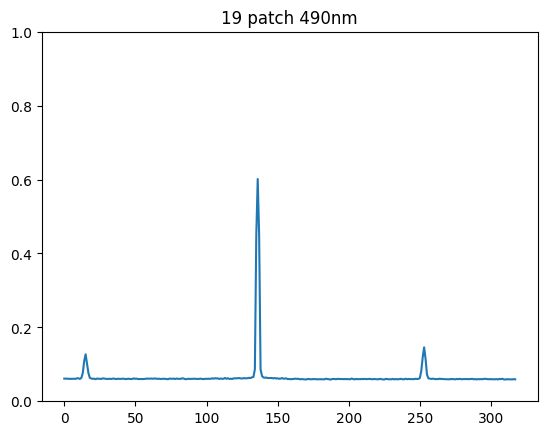

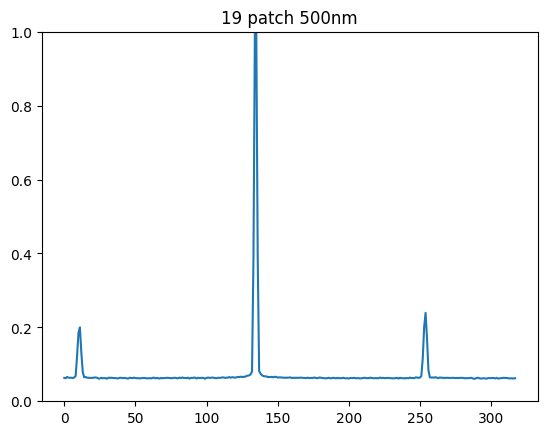

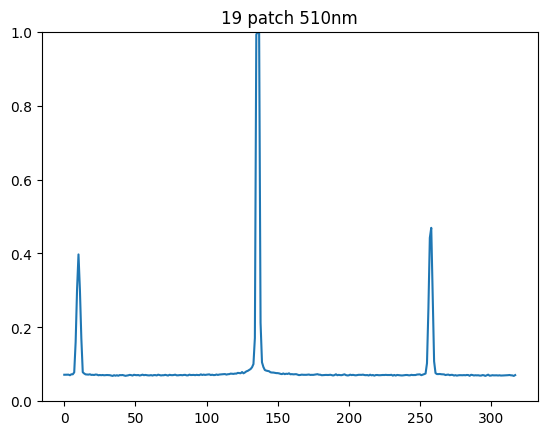

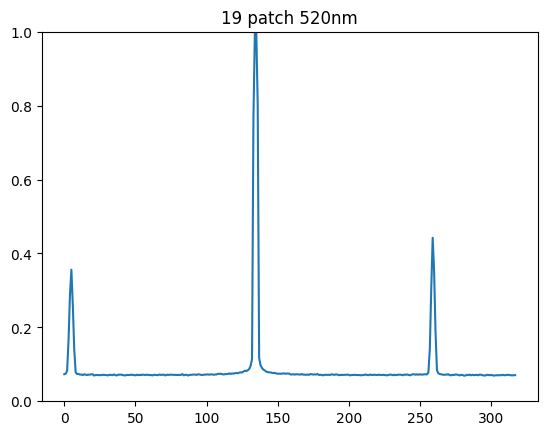

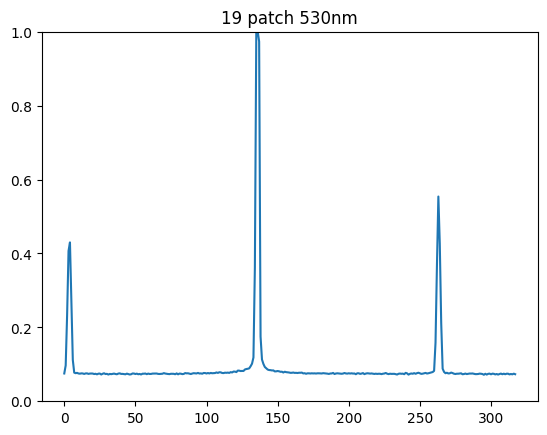

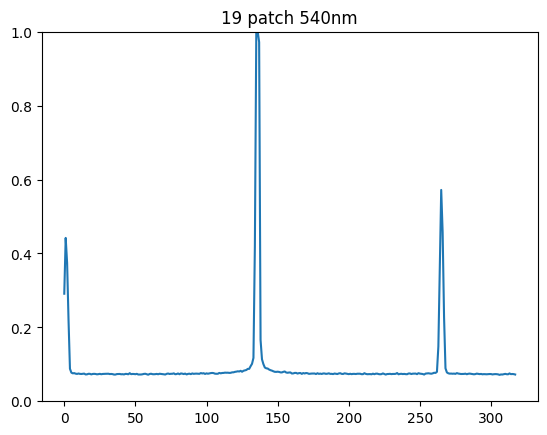

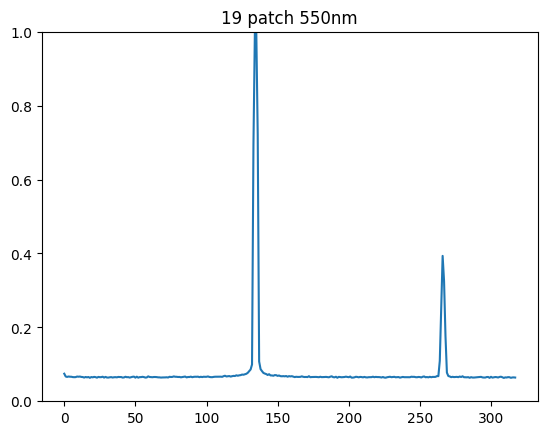

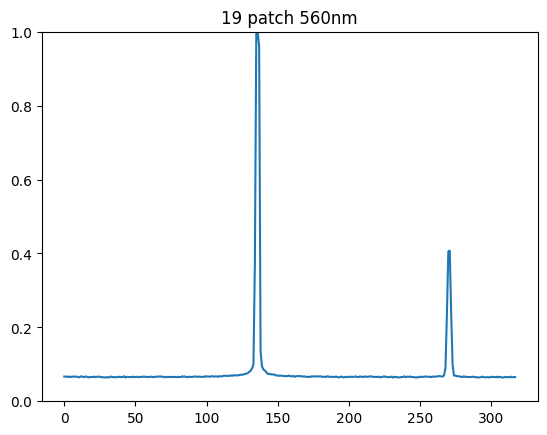

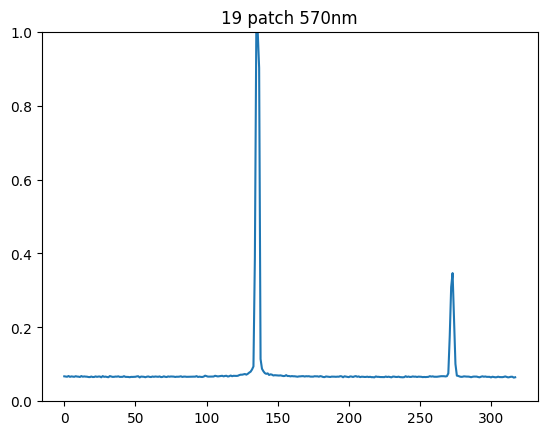

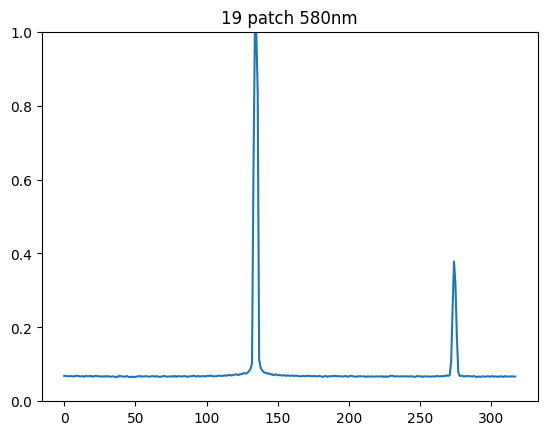

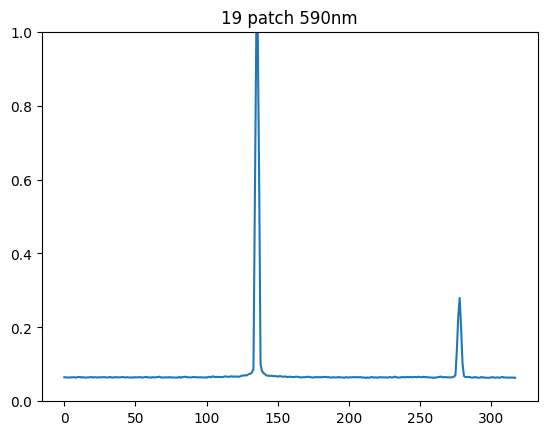

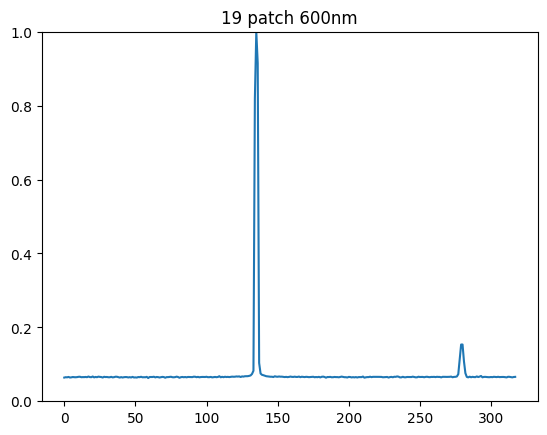

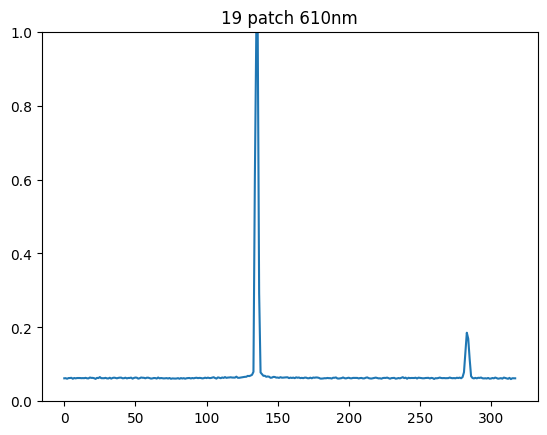

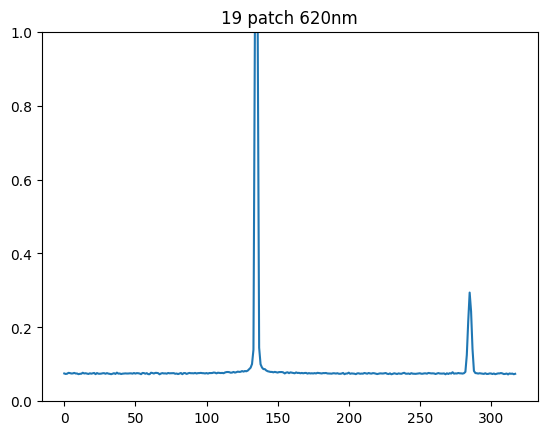

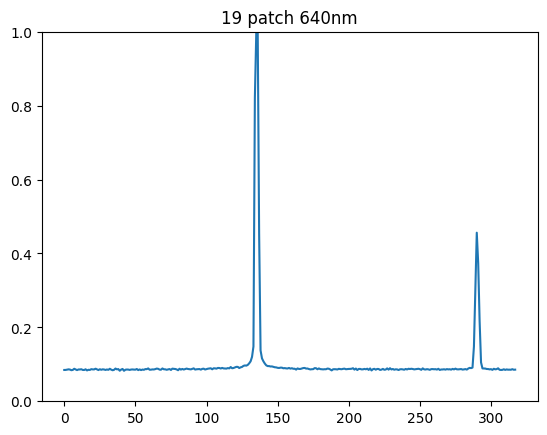

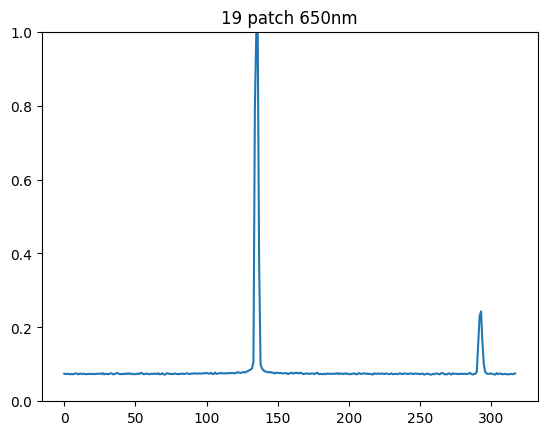

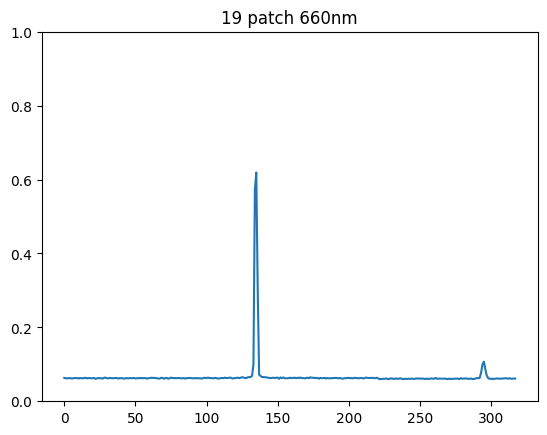

In [14]:
# patches_rgb_real (318, 24, 23)

for p in range(19,20):
    for w in range(len(wvls)):
        plt.figure()
        plt.ylim([0, 1])
        plt.plot(patches_rgb_real[:,p, w]), plt.title('%02d patch %dnm'%(p, wvls[w]))
    
        max_idx = np.argmax(patches_rgb_real[:,p,w])
        zero_illum_idx[p, w] = max_idx

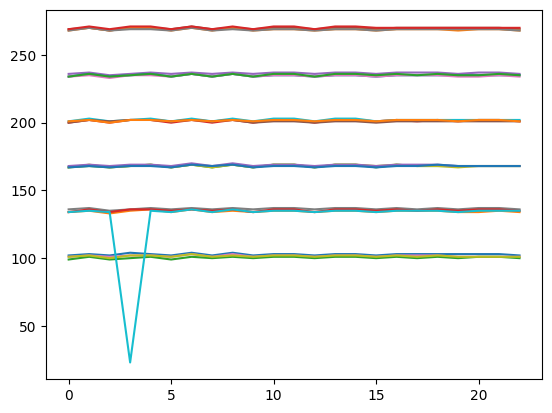

In [11]:
for p in range(n_patches):
    plt.plot(zero_illum_idx)
    
# 19 번 패치의 3번째 wvl : 23 index가 zero order라고 뜸 (outlier) > 메뉴얼하게 변경
# zero_illum_idx[19,3] = zero_illum_idx[19,4] 

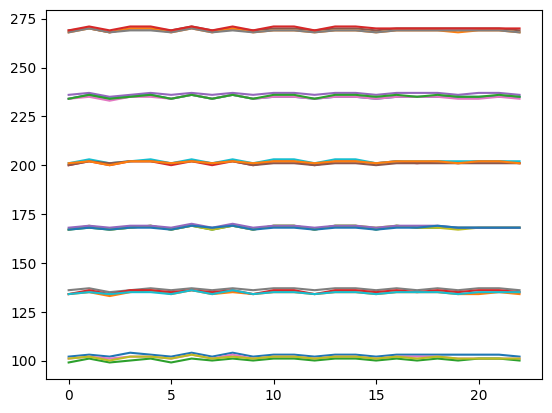

In [17]:
for p in range(n_patches):
    plt.plot(zero_illum_idx[p]) # zero order index

In [19]:
diff = zero_illum_idx - peak_illum_idx

Text(0, 0.5, 'difference 0-order first order 430nm index')

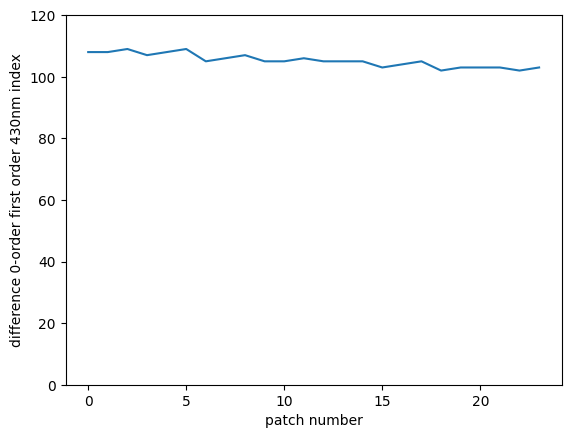

In [46]:
x = np.arange(0, n_patches)
plt.ylim([0, 120])
plt.plot(x, abs(diff[:,0]))
plt.xlabel('patch number')
plt.ylabel('difference 0-order first order 430nm index')


Text(0, 0.5, 'difference first order 430nm and 660nm index')

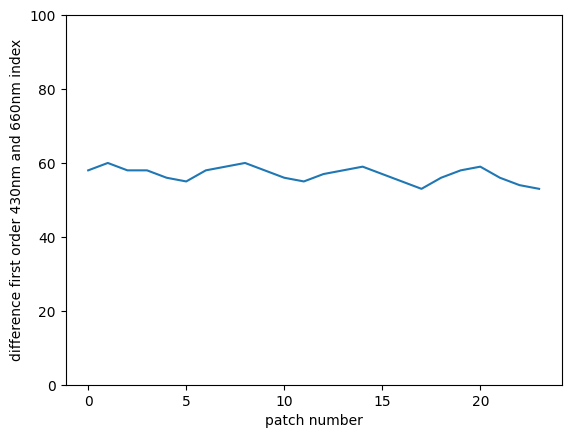

In [59]:
x = np.arange(0, n_patches)
plt.ylim([0, 100])
plt.plot(x, abs(peak_illum_idx[:,0] - peak_illum_idx[:,-1]))
plt.xlabel('patch number')
plt.ylabel('difference first order 430nm and 660nm index')

00 patch slope 58
01 patch slope 60
02 patch slope 58
03 patch slope 58
04 patch slope 56
05 patch slope 55
06 patch slope 58
07 patch slope 59
08 patch slope 60
09 patch slope 58
10 patch slope 56
11 patch slope 55
12 patch slope 57
13 patch slope 58
14 patch slope 59
15 patch slope 57
16 patch slope 55
17 patch slope 53
18 patch slope 56
19 patch slope 58
20 patch slope 59
21 patch slope 56
22 patch slope 54
23 patch slope 53


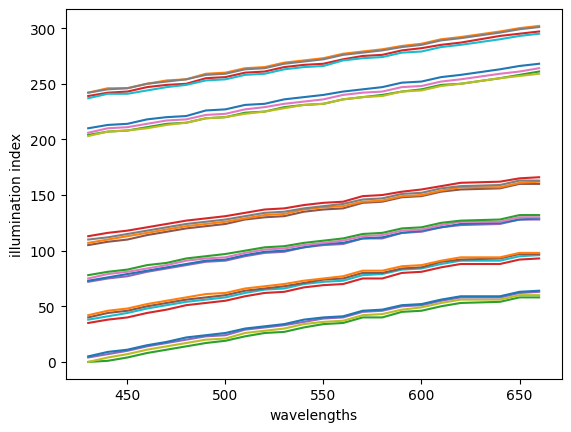

In [58]:
wvls 
pfirst_patch = [0, 6, 12, 18, 1, 7, 13, 19]
for p in range(n_patches):
    if p not in pfirst_patch:
        plt.plot(wvls, peak_illum_idx[p,::-1])
        inv_peak_illum_idx = peak_illum_idx[p,::-1]
        a = abs(inv_peak_illum_idx[0] - inv_peak_illum_idx[-1])
        print("%02d patch slope %d"%(p, a))
    else:
        plt.plot(wvls, peak_illum_idx[p])
        a = abs(peak_illum_idx[p,0] - peak_illum_idx[p,-1])
        print("%02d patch slope %d"%(p, a))
    plt.xlabel('wavelengths')
    plt.ylabel('illumination index')